# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.inspection import permutation_importance


from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor

from matplotlib import pyplot 

from time import time


RANDOM_STATE = 123


warnings.filterwarnings('ignore')



In [2]:
def quantile_del(data, columns):    
    
    for name in columns:
        
        before = len(data)
            
        # граничные значения    
        q1 = data[name].quantile(.25)
        q3 = data[name].quantile(.75)
        low = q1 - 1.5*(q3 - q1)
        high = q3 + 1.5*(q3 - q1)
    
        # перезапись того, что внутри значений
        data = data.loc[(data[name]>=low) & (data[name]<=high)]
        after = len(data)
        print('Процент отброшенных данных в выборке после обработки параметра', name, ':', round((before-after)*100/before, 2),'%\nколичество отброшенных строк:', before-after)
        print('Было строк:', before)

## Подготовка данных

### Общие сведения

In [3]:
df = pd.read_csv('/datasets/autos.csv')

In [4]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
df.sample(8)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
80367,2016-03-09 15:48:42,1650,sedan,2000,manual,0,c_klasse,150000,4,petrol,mercedes_benz,no,2016-03-09 00:00:00,0,23795,2016-03-15 00:46:18
311080,2016-03-10 14:47:20,4850,wagon,2004,auto,180,a6,150000,2,gasoline,audi,NaN,2016-03-10 00:00:00,0,39615,2016-03-23 11:47:30
161908,2016-04-03 19:42:45,6399,bus,2008,manual,143,5_reihe,125000,3,gasoline,mazda,no,2016-04-03 00:00:00,0,86668,2016-04-05 20:16:01
46765,2016-03-17 18:58:37,1099,sedan,1995,manual,101,a4,150000,2,petrol,audi,NaN,2016-03-17 00:00:00,0,42659,2016-03-20 21:19:17
273226,2016-03-19 09:54:53,49,small,1999,NaN,0,polo,100000,0,NaN,volkswagen,NaN,2016-03-19 00:00:00,0,6528,2016-04-06 10:15:49
77230,2016-03-19 14:56:04,400,wagon,1998,manual,0,vectra,150000,0,petrol,opel,no,2016-03-19 00:00:00,0,74172,2016-04-06 22:45:48
312799,2016-03-23 19:55:22,2350,wagon,1999,manual,150,bora,150000,6,lpg,volkswagen,no,2016-03-23 00:00:00,0,13347,2016-03-23 19:55:22
299306,2016-03-20 07:58:53,2000,sedan,2002,manual,120,6_reihe,150000,11,petrol,mazda,no,2016-03-20 00:00:00,0,44807,2016-03-25 06:15:21


In [6]:
df.index.name = 'index'

### Полные дубли

In [7]:
df.duplicated().sum() 

4

Удаляем полные дубликаты с переназначением индексов

In [8]:
df.drop_duplicates().reset_index() 
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

### Анализ параметров

Длина первоначального датасета

In [9]:
len_df = len(df)

На всякий случай, если вдруг придётся обратиться к первоначальной информации, скопирую данные.

In [10]:
df_original = df.copy() 

    В датасете 354369 оригинальных строк, 16 параметров типа int64 и object. Точно есть пропуски.

Признаки

	• DateCrawled — дата скачивания анкеты из базы
	• VehicleType — тип автомобильного кузова
	• RegistrationYear — год регистрации автомобиля
	• Gearbox — тип коробки передач
	• Power — мощность (л. с.)
	• Model — модель автомобиля
	• Kilometer — пробег (км)
	• RegistrationMonth — месяц регистрации автомобиля
	• FuelType — тип топлива
	• Brand — марка автомобиля
	• Repaired — была машина в ремонте или нет
	• DateCreated — дата создания анкеты
	• NumberOfPictures — количество фотографий автомобиля
	• PostalCode — почтовый индекс владельца анкеты (пользователя)
	• LastSeen — дата последней активности пользователя
    
Целевой признак

      Price — цена (евро)
      

#### LastSeen, DateCrawled, PostalCode
      
    LastSeen и DateCrawled можно было бы преобразовать в тип DateTime, но делать этого не будем, потому что эти параметры не связаны с продаваемым автомобилем, только с объявлением.
 
    PostalCode - вызывает вопросы. С одной стороны, климат влияет на состояние автомобиля, но с другой, в одной Москве индексов очень много (как пример). Также, эксплуатация автомобиля может проходить в нескольких климатических зонах, разные владельцы по-разному ухаживают за автомобилями в одном и том же регионе. В связи со всем перечисленным считаю эту колонку не информативной и предлагаю тоже удалить.

   


In [11]:
df = df.drop(['DateCrawled', 'LastSeen', 'PostalCode'], axis='columns')

#### RegistrationYear, RegistrationMonth, DateCreated 
 
 Теперь надо обдумать информацию из столбца RegistrationYear - насколько актуальным будут годы постановки на учёт автомобиля. Первый автомобиль создан в 1885 году, но вряд ли старинные автомобили массово привлекательны для водителей. Нужно как-то подобрать диапазон лет для удаления строк с неподходящими значениями.

In [12]:
df['RegistrationYear'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

Видим странные значения как в меньшую сторону от 20 века, так и в большую.


In [13]:
df['RegistrationMonth'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

Видимо, некоторые владельцы не считают важным указывать месяц регистрации. Поскольку какой-то логики, по которой мжно восстановитьзначения в этом параметре, не найти, посмотрим, сколко процентов от всех данных составляют строки с нулевым месяцем.

In [14]:
round(len(df[df['RegistrationMonth']==0])*100/len_df, 2)

10.54

Довольно много, удалять не очень хочется, надо заменить. Этот параметр нам нужен для выбора строк, но не для моделирования, поэтому если и будет перебор каких-то значений, то на модели он не скажется. Поэтому заменим 0 на 1, будто машину поставили на учёт в январе. Это минимально возможное значение параметра, и оно позволит максимально точно отсечь те строки, в которых дата регистрации позже, чем дата подачи объявления.

In [15]:
df['RegistrationMonth'] = df['RegistrationMonth'].replace(0,1)
df['RegistrationMonth'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])


"Для иностранных моделей энтузиасты пользовались класси­фикациями FIVA (Международной организации старинных транспортных средств), которые ранжируют автомобили по возрасту, степени аутентич­ности и редкости модели. Машины в возрасте 20–29 лет относят к категории «янгтаймеров» (youngtimer vehicle), на которых предлагается ездить каждый день. Всё, что старше, — «исторические автомобили» (historical vehicle), для которых главное — это аутентичное состояние." - цитата по https://auto.ru/mag/article/kak-priznat-staruyu-mashinu-raritetom-i-zachem-eto-nuzhno/

Сделаем преобразование типа в DateTime у DateCreated, чтоб узнать, к каким годам относятся объявления о продаже.

In [16]:
df['DateCreated'] = pd.to_datetime(df['DateCreated']) 
df['DateCreated'].dt.year.sort_values().unique()

array([2014, 2015, 2016])

Тогда отсчитаем от 2014 года 58 лет назад (удвоим указанный промежуток для сохранения большего количества строк) и так ограничим год регистрации снизу, а 2016 возьмём как текущий, больше которого дата регистрации не может быть.

In [17]:
len_before = len(df)
print('В сете', len_before , 'строк')

df = df.loc[(df['RegistrationYear']<=2016) & (df['RegistrationYear']>=(2016-58))]

len_after = len(df)
print('В сете осталось', len_after, 'строк\nудалено', len_before - len_after, 'строк\nВ процентах удалено',\
     round((len_before - len_after)*100/len_before, 2), '% строк')

В сете 354369 строк
В сете осталось 339474 строк
удалено 14895 строк
В процентах удалено 4.2 % строк


Логично, что автомобиль сначала изготовили и только потом повесили объявление о его продаже. Оставим в сете только те строки, в которых дата размещения анкеты больше даты регистрации автомобиля.

Стобцы RegistrationYear и RegistrationMonth надо привести к одному значению вместо двух. И чтобы было удобно и просто потом посчитать интересующую разницу, приведём DateCreated, RegistrationYear и RegistrationMonth к размерности "месяц".

После этого колонка DateCreated нам не нужна, она не связана с ценой на автомобиль, удалю её.

Перевод в месяцы:

In [18]:
df['DateCreated'] = df['DateCreated'].dt.year*12 + df['DateCreated'].dt.month 
df['DateCreated'].unique()

array([24195, 24196, 24194, 24183, 24191, 24193, 24192, 24171, 24189,
       24188, 24186])

Получили немного чисел в удобном и простом виде.

Теперь преобразуем дату регистрации к той же размерности и удалим стобцы RegistrationYear и RegistrationMonth.


In [19]:
df['RegistrationMonthTime'] = df['RegistrationYear']*12 + df['RegistrationMonth']

In [20]:
df['RegistrationMonthTime'].unique()

array([23917, 24137, 24056, 24018, 24103, 23950, 23767, 24176, 23977,
       24060, 24072, 23951, 24050, 24135, 24193, 24090, 24049, 24112,
       24031, 23969, 23890, 24033, 24107, 23773, 24039, 23941, 24198,
       23930, 24089, 24059, 24196, 23893, 24035, 23816, 23881, 24028,
       24083, 24092, 24102, 23996, 23978, 24151, 24100, 24108, 24061,
       24073, 23986, 23939, 23944, 24051, 24124, 24082, 24104, 24008,
       23913, 24013, 23919, 23967, 24106, 24160, 24044, 24002, 24076,
       24195, 24001, 23934, 24069, 23974, 24068, 24019, 24120, 24045,
       23811, 24109, 24041, 23999, 24098, 23945, 24052, 23995, 23972,
       23905, 23997, 23943, 24111, 24081, 24027, 23897, 23989, 23960,
       24010, 24125, 24005, 24025, 23882, 23952, 24118, 24024, 24149,
       23958, 24071, 24048, 24088, 23961, 24011, 24130, 23987, 23953,
       24037, 23824, 23955, 24057, 24042, 24113, 24058, 24038, 24095,
       23925, 24034, 24021, 23935, 23879, 24096, 23982, 24136, 24079,
       24040, 24078,

In [21]:
df.sample(8)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,RegistrationMonthTime
index,,,,,,,,,,,,,,
181836,10950,bus,1991,manual,77,transporter,150000,10,gasoline,volkswagen,no,24195,0,23902
103847,1000,small,2001,manual,75,lupo,150000,1,petrol,volkswagen,no,24195,0,24013
87592,300,other,1998,manual,63,other,100000,3,petrol,ford,yes,24195,0,23979
325691,2650,coupe,2002,manual,143,c_klasse,150000,10,petrol,mercedes_benz,no,24195,0,24034
236223,150,small,2000,manual,0,punto,150000,3,petrol,fiat,yes,24195,0,24003
85909,3200,wagon,1995,manual,193,3er,150000,12,petrol,bmw,NaN,24195,0,23952
110311,575,sedan,1999,auto,170,vectra,150000,4,petrol,opel,no,24195,0,23992
163801,12500,sedan,2006,manual,163,a4,125000,7,petrol,audi,no,24195,0,24079


Теперь отфильтруем строки по датам - RegistrationMonthTime должна быть меньше DateCreated.

In [22]:
len_before = len(df)
print('В сете было', len_before , 'строк')

df = df.loc[df['RegistrationMonthTime']<df['DateCreated']]

len_after = len(df)
print('В сете осталось', len_after, 'строк\nудалено', len_before - len_after, 'строк\nВ процентах удалено',\
     round((len_before - len_after)*100/len_df, 2), '% строк')

В сете было 339474 строк
В сете осталось 333565 строк
удалено 5909 строк
В процентах удалено 1.67 % строк


Оставим столбец с годом регистрации - неправильные значения мы отфильтровали, оставляем более удобный вид данных.

In [23]:
df = df.drop(['RegistrationMonthTime', 'RegistrationMonth', 'DateCreated'], axis='columns')

Проанализируем значения в других столбцах и начнём с NumberOfPictures, потому что во всех сэмплах видим нулевые значения, привлекает внимание.

In [24]:
df['NumberOfPictures'].unique()

array([0])

Колонка "NumberOfPictures" содержит только одно значение - '0'. Не повлияет на итог, удаляем столбец.


In [25]:
df = df.drop(['NumberOfPictures'], axis='columns')

#### Числовые параметры Price, Power, Kilometer


In [26]:
df.sample(8)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
index,,,,,,,,,,
60886,5500,sedan,2003,manual,170,5er,150000,petrol,bmw,no
131447,0,small,1998,manual,41,cuore,150000,petrol,daihatsu,yes
170675,8200,small,2013,manual,87,corsa,20000,petrol,opel,no
328043,0,NaN,2000,NaN,0,ibiza,150000,NaN,seat,NaN
89178,2000,sedan,1999,manual,101,focus,150000,petrol,ford,NaN
53811,2000,small,2001,manual,115,NaN,90000,petrol,volkswagen,NaN
323435,12250,sedan,2012,manual,140,astra,50000,petrol,opel,no
58692,15500,wagon,2012,auto,240,c5,150000,gasoline,citroen,NaN


In [27]:
columns = df.columns
columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')

Беру те, которые мы ещё не обрабатывали.

In [28]:
columns_numeric = ['Price', 'Power', 'Kilometer']

In [29]:
df[columns_numeric].describe()

,Price,Power,Kilometer
count,333565.000000,333565.000000,333565.000000
mean,4506.497336,111.493982,128044.399143
std,4555.860851,183.770938,37853.864270
min,0.000000,0.000000,5000.000000
25%,1100.000000,69.000000,125000.000000
50%,2800.000000,105.000000,150000.000000
75%,6500.000000,143.000000,150000.000000
max,20000.000000,20000.000000,150000.000000


Обратим внимание на то, что пробег имеет медиану такую, же как и максимальное значение. Посмотрим, сколько авто с таким большим пробегом.

##### Kilometer

In [30]:
df.groupby('Kilometer')['Kilometer'].count()

Kilometer
5000        5624
10000       1119
20000       3766
30000       4275
40000       4780
50000       6015
60000       7200
70000       8276
80000       9638
90000      11056
100000     14193
125000     34554
150000    223069
Name: Kilometer, dtype: int64

In [31]:
print('Процент строк в сете с пробегом 150000 км -',round(len(df.loc[df['Kilometer']==150000])*100/len_df, 2))

Процент строк в сете с пробегом 150000 км - 62.95


То есть, больше половины автомобилей указывают пробег как одно значение. Видимо, вариации значений выше 150000 не имеет особого смысла множить.

Перезапишем для кодировки перечень числовых и категориальных характеристик - перенесём километры в категории и уберём цену, потому что она является целевым признаком.

In [32]:
columns_numeric = ['Power'] 

columns_cat = ['VehicleType', 'RegistrationYear', 'Gearbox', 'Model', 'Kilometer', 'FuelType', 'Brand', 'Repaired'] 

##### Power

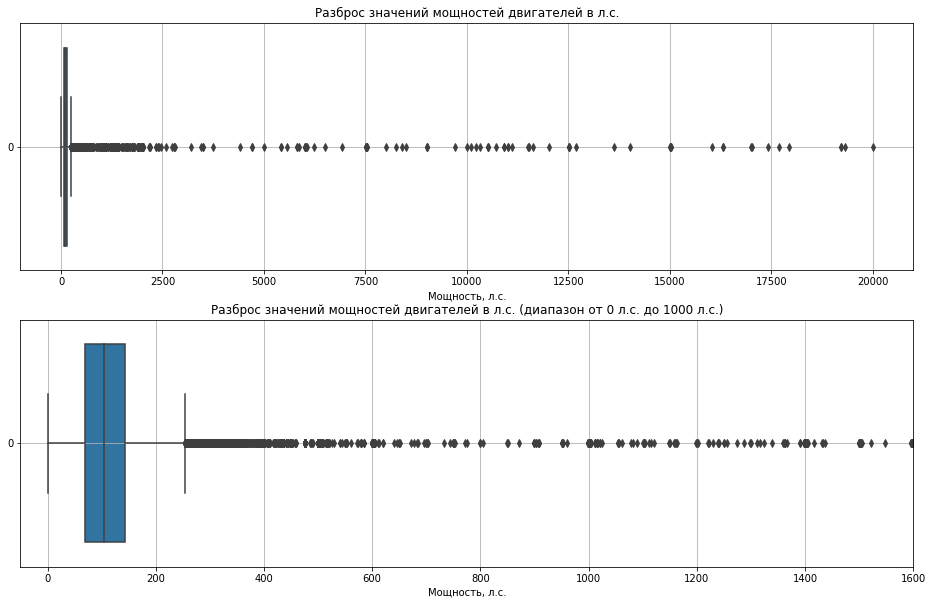

In [33]:
f, (ax1, ax2) = plt.subplots(2,1)
sns.boxplot(data=df['Power'], orient='horizontal', ax=ax1)
ax1.set(xlabel='Мощность, л.с.', title='Разброс значений мощностей двигателей в л.с.')
ax1.grid(True)
sns.boxplot(data=df['Power'], orient='horizontal', ax=ax2)
ax2.set(xlabel='Мощность, л.с.', xlim=(-50,1600),\
        title='Разброс значений мощностей двигателей в л.с. (диапазон от 0 л.с. до 1000 л.с.)')
ax2.grid(True)
f.set_figwidth(16)
f.set_figheight(10)

Cамое большое значение - 1600, самое маленькое - 0,75 за всю историю автомобилестроения, как говорит поиск в интернете.


Можем изменить значения больше 10000 на два порядка, предположив, что каким-то образом оказалась пропущена запятая для отделения целой части.

In [34]:
df.loc[df['Power']>=10000, 'Power'] = df.loc[df['Power']>=10000, 'Power'] /100

Посмотрим, какие бренды представлены в значениях больше 400 л. с.

In [35]:
brand_power = df.loc[df['Power']>400].groupby('Brand')['Power'].count()

In [36]:
brand_power.sort_values(ascending=False)

Brand
audi              132
mercedes_benz      96
volkswagen         93
bmw                63
opel               46
porsche            43
ford               28
renault            21
fiat               13
chevrolet          12
citroen            12
sonstige_autos     11
seat               10
nissan              8
peugeot             6
toyota              5
lancia              4
smart               4
chrysler            4
mini                3
jaguar              3
honda               3
volvo               3
mitsubishi          2
mazda               2
jeep                2
skoda               2
suzuki              2
kia                 1
hyundai             1
subaru              1
daewoo              1
Name: Power, dtype: int64

    audi в гугле имеет максимум 500 лс на автомобилях массового производства
    mercedes_benz - 730 лс
    volkswagen - 400 лс
    bmw - 632 лс
    
То есть, за максимум можно взять 730 лс, а остальное заполнить в соответствии со средним значением для модели

In [37]:
df.loc[df['Power']>730,'Power'] = np.nan

In [38]:
df["Power"] = df["Power"].fillna(df.groupby("Model")["Power"].transform("mean"))

In [39]:
df["Power"].isna().sum()

33

In [40]:
df.loc[df["Power"].isna()]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
index,,,,,,,,,,
7720,1500,small,2000,manual,NaN,NaN,150000,petrol,honda,NaN
21609,200,small,2000,manual,NaN,NaN,125000,petrol,lancia,NaN
24591,1499,sedan,1998,manual,NaN,NaN,100000,petrol,opel,NaN
46073,0,sedan,2002,manual,NaN,NaN,150000,gasoline,seat,no
46941,15000,coupe,2013,auto,NaN,NaN,10000,petrol,sonstige_autos,no
56059,2450,bus,1992,manual,NaN,NaN,150000,NaN,volkswagen,NaN
59887,300,sedan,2004,manual,NaN,NaN,150000,NaN,ford,yes
69741,500,small,1997,manual,NaN,NaN,150000,NaN,audi,NaN
91751,4500,suv,2004,auto,NaN,NaN,125000,petrol,nissan,yes


Для модели other не получится восстановить power. Удаляю.

In [41]:
df = df.dropna(subset=['Power'])

##### Price

Теперь рассмотрим цену.

<AxesSubplot:>

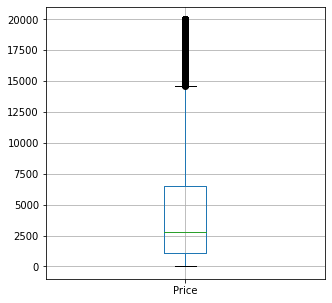

In [42]:
df.boxplot(column='Price',figsize=(5,5))

In [43]:
print('Автомобилей стоимостью ниже 100 евро в сете в процентах:', round(len(df.loc[df['Price']<=100])*100/len_df,2))

Автомобилей стоимостью ниже 100 евро в сете в процентах: 3.66


Выделю эти автомобили в отдельный датасет и после построения модели определю их стоимость. Сделаю это в конце корректировки всех данных, чтоб и эти строки были исправлены.

#### Категориальные параметры

Вспомним, что мы определили, как категории.

In [44]:
columns_cat

['VehicleType',
 'RegistrationYear',
 'Gearbox',
 'Model',
 'Kilometer',
 'FuelType',
 'Brand',
 'Repaired']

RegistrationYear, Kilometer отработаны.
###### В столбцах VehicleType, Gearbox, Model, FuelType, Repaired надо подумать над заполнением пустот.


##### Repaired 
— была машина в ремонте или нет.


In [45]:
df['Repaired'].sort_values().unique()

array(['no', 'yes', nan], dtype=object)

Предположим, что пропуск означает, что машина не была в ремонте. Тогда, заполнив пропуски значением 'no', Repaired можно привести к типу boolean.


In [46]:
df['Repaired'] = df['Repaired'].fillna('no')
df.groupby('Repaired')['Power'].count()

Repaired
no     299417
yes     34115
Name: Power, dtype: int64

In [47]:
df['Repaired'].sort_values().unique()

array(['no', 'yes'], dtype=object)

##### Brand, Model


In [48]:
df['Brand'].sort_values().unique()

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

Как будто нормально, нет опечаток, повторов из-за опечаток и пустот.

In [49]:
df['Model'].sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

В моделях есть пропуски. Посмотрим, сколько их.

In [50]:
print('Автомобилей неопределённой модели в процентах:', round(len(df.loc[df['Model'].isna()])*100/len_df,2))
print('Автомобилей неопределённой модели:', len(df.loc[df['Model'].isna()]))

Автомобилей неопределённой модели в процентах: 4.72
Автомобилей неопределённой модели: 16709


Можно удалить, потому что не восстановить никак. Можно ввести категорию 'other'. Например, пользователь не посчитал нужным указывать модель, или, например, была возможность выбирать из выпадающего списка, и нужной модели не оказалось, поэтому возник пропуск.

In [51]:
df['Model'] = df['Model'].fillna('other')

In [52]:
columns_cat

['VehicleType',
 'RegistrationYear',
 'Gearbox',
 'Model',
 'Kilometer',
 'FuelType',
 'Brand',
 'Repaired']

##### VehicleType 


In [53]:
df['VehicleType'].isna().sum()

17025

In [54]:
df.loc[df['VehicleType'].isna()].sample(8)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
index,,,,,,,,,,
94905,8500,NaN,1998,NaN,0.0,other,90000,NaN,volkswagen,no
85074,500,NaN,1995,manual,150.0,other,150000,NaN,bmw,no
236014,1250,NaN,1985,manual,54.0,golf,150000,gasoline,volkswagen,no
156607,200,NaN,2000,NaN,0.0,corsa,20000,NaN,opel,no
344141,0,NaN,1990,NaN,0.0,601,40000,NaN,trabant,no
102922,2200,NaN,2016,manual,0.0,golf,125000,petrol,volkswagen,no
133251,650,NaN,1996,NaN,0.0,other,150000,NaN,citroen,no
340957,0,NaN,1985,manual,75.0,caddy,150000,petrol,volkswagen,no


Тип транспортного средства можно восстановить по модели.

In [55]:
auto_model = df.loc[df['VehicleType'].isna()]['Model'].unique()


In [56]:
auto_model.sort()
auto_model

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse',
       'accord', 'agila', 'alhambra', 'almera', 'altea', 'antara',
       'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse',
       'b_max', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1',
       'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max', 'c_reihe', 'caddy',
       'calibra', 'carisma', 'carnival', 'cayenne', 'cc', 'ceed',
       'charade', 'cherokee', 'citigo', 'civic', 'cl', 'clio', 'clk',
       'clubman', 'colt', 'combo', 'cooper', 'cordoba', 'corolla',
       'corsa', 'cr_reihe', 'croma', 'cuore', 'cx_reihe', 'defender',
       'delta', 'doblo', 'ducato', 'duster', 'e_klasse', 'eos', 'escort',
       'espace', 'fabia', 'fiesta', 'focus', 'forester', 'forfour',
       'fortwo', 'fox

In [57]:
df.loc[df['VehicleType'].notna()].groupby('Model')['VehicleType'].unique()

Model
100                       [wagon, sedan, coupe, convertible]
145                             [small, sedan, coupe, other]
147                 [sedan, small, wagon, coupe, suv, other]
156                      [wagon, sedan, coupe, other, small]
159                                           [sedan, wagon]
                                 ...                        
yaris                      [small, bus, other, wagon, sedan]
yeti                                     [suv, other, wagon]
ypsilon                                 [small, convertible]
z_reihe                          [convertible, coupe, sedan]
zafira     [bus, other, wagon, small, suv, sedan, convert...
Name: VehicleType, Length: 250, dtype: object

Заменю модой, ориентируясь на модель, мощность двигателя, год регистрации.

In [58]:
df['VehicleType'] = df.groupby(['Model','RegistrationYear', 'Power'])['VehicleType'].transform(lambda x: x.fillna((x.mode()[0] if x.count()!=0 else "other")))

Посмотрим, остались ли пропуски.

In [59]:
df['VehicleType'].isna().sum()

0

Прекрасно. Можно не удалять строки.

##### Gearbox, FuelType


In [60]:
df['Gearbox'].sort_values().unique()

array(['auto', 'manual', nan], dtype=object)

Помимо механики и автомата, ещё бывают роботы и вариаторы. Предлагаю пропуски заменить на 'other'.


In [61]:
df['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [62]:
print('Автомобилей c неопределённой коробкой в процентах:', round(len(df.loc[df['Gearbox'].isna()])*100/len_df,2))
print('Автомобилей c неопределённой коробкой:', len(df.loc[df['Gearbox'].isna()]))

Автомобилей c неопределённой коробкой в процентах: 4.87
Автомобилей c неопределённой коробкой: 17262


In [63]:
print('Автомобилей неопределённым типом топлива в процентах:', round(len(df.loc[df['FuelType'].isna()])*100/len_df, 2))
print('Автомобилей неопределённым типом топлива модели:', len(df.loc[df['FuelType'].isna()]))

Автомобилей неопределённым типом топлива в процентах: 7.0
Автомобилей неопределённым типом топлива модели: 24814


Без коробки и топлива машина не ездит, поэтому все пустоты опять попробуем заменить модой.

In [64]:
df['FuelType'] = df.groupby(['Model','RegistrationYear', 'Power'])['FuelType'].transform(lambda x: x.fillna((x.mode()[0] if x.count()!=0 else "other")))

In [65]:
df['Gearbox'] = df.groupby(['Model','RegistrationYear', 'Power'])['Gearbox'].transform(lambda x: x.fillna((x.mode()[0] if x.count()!=0 else "other")))

Обработка данных закончена.
Отделяю от датасета данные с ценой ниже 100 евро.

In [66]:
df_low_price = df.loc[df['Price']<=100]

In [67]:
df = df.loc[df['Price']>100]

После обработки данных могли появиться новые полные дкбли, поэтому проверю датасет ещё раз.

In [68]:
df.duplicated().sum()

52771

Довольно много, но ничего не поделаешь, надо от них избавиться.

In [69]:
df.drop_duplicates().reset_index()

,index,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,0,480,sedan,1993,manual,0.0,golf,150000,petrol,volkswagen,no
1,1,18300,coupe,2011,manual,190.0,other,125000,gasoline,audi,yes
2,2,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,no
3,3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no
4,4,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...,...
267780,354362,3200,sedan,2004,manual,225.0,leon,150000,petrol,seat,yes
267781,354365,2200,sedan,2005,manual,0.0,other,20000,petrol,sonstige_autos,no
267782,354366,1199,convertible,2000,auto,101.0,fortwo,125000,petrol,smart,no
267783,354367,9200,bus,1996,manual,102.0,transporter,150000,gasoline,volkswagen,no


In [70]:
print('Всего удалено данных из датасета', round((len_df-len(df))*100/len_df, 2),'%')

Всего удалено данных из датасета 9.54 %


### Матрица корреляций

<AxesSubplot:>

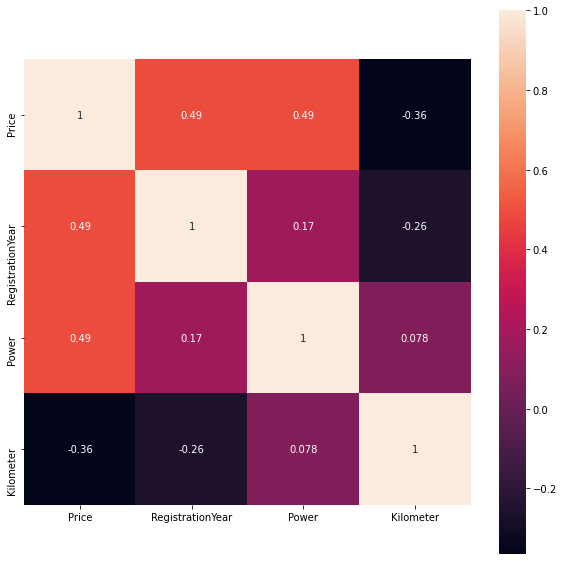

In [71]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, square=True)

Видим прямую зависимость от Года регистрации и мощности двигателя и обратную от километража. 


### Кодирование данных


#### Целевой признак, фичи

Теперь делю на тестовую и обучающую выборки в отношении 20/80, потому что хочу использовать кроссвалидацию, для которой валидационная выборка не нужна.

In [72]:
target = df['Price']

features = df.drop(['Price'], axis=1)


In [73]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=RANDOM_STATE)

Поскольку модели CatBoost и LGBM умеют сами обрабатывать категориальные параметры, сделаем для них только шкалирование числовых параметров. Для дерева обработаем и категориальные признаки.

In [74]:
features_train_code = features_train.copy()
features_test_code = features_test.copy()

Вспомним, как разделились данные по типу признака.

Числовые:

In [75]:
columns_numeric

['Power']

Категориальные:

In [76]:
columns_cat

['VehicleType',
 'RegistrationYear',
 'Gearbox',
 'Model',
 'Kilometer',
 'FuelType',
 'Brand',
 'Repaired']

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320556 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             320556 non-null  int64  
 1   VehicleType       320556 non-null  object 
 2   RegistrationYear  320556 non-null  int64  
 3   Gearbox           320556 non-null  object 
 4   Power             320556 non-null  float64
 5   Model             320556 non-null  object 
 6   Kilometer         320556 non-null  int64  
 7   FuelType          320556 non-null  object 
 8   Brand             320556 non-null  object 
 9   Repaired          320556 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 26.9+ MB


#### Ordinal Encoder

Кодируем категориальные признаки для дерева.

In [78]:
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=352) 
encoder.fit(features_train[columns_cat])

features_train_code[columns_cat] = encoder.transform(features_train_code[columns_cat])
features_test_code[columns_cat] = encoder.transform(features_test_code[columns_cat])

#### Масштабиование количественных признаков

Кодируем числовые признаки для всех моделей.

In [79]:
scaler = StandardScaler()
scaler.fit(features_train[columns_numeric])

StandardScaler()

In [80]:
features_train[columns_numeric] = scaler.transform(features_train[columns_numeric])
features_test[columns_numeric] = scaler.transform(features_test[columns_numeric])
features_train_code[columns_numeric] = scaler.transform(features_train[columns_numeric])
features_test_code[columns_numeric] = scaler.transform(features_test[columns_numeric])

In [81]:
features_train.sample(8)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
index,,,,,,,,,
72743,bus,2012,auto,0.483978,galaxy,60000,gasoline,ford,no
29669,sedan,2010,auto,0.195630,other,60000,petrol,bmw,no
43909,small,1999,auto,-0.893687,fortwo,150000,petrol,smart,no
145381,wagon,2005,auto,1.941740,5er,150000,gasoline,bmw,no
25471,small,1988,manual,-1.758733,other,60000,petrol,citroen,no
2309,wagon,2004,manual,1.076694,5er,150000,gasoline,bmw,no
103538,sedan,2007,manual,0.964559,passat,150000,gasoline,volkswagen,no
237762,wagon,2010,auto,0.532036,a4,150000,gasoline,audi,no


In [82]:
features_train_code.sample(8)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
index,,,,,,,,,
233869,4.0,40.0,1.0,-1.765864,33.0,12.0,6.0,20.0,0.0
291037,3.0,37.0,1.0,-1.759961,17.0,12.0,6.0,19.0,0.0
325749,4.0,49.0,1.0,-1.752006,166.0,12.0,2.0,39.0,0.0
335095,0.0,49.0,1.0,-1.750210,14.0,12.0,2.0,19.0,0.0
184543,5.0,55.0,1.0,-1.764837,120.0,4.0,6.0,30.0,0.0
132240,4.0,42.0,1.0,-1.755599,59.0,12.0,6.0,20.0,0.0
353955,2.0,47.0,0.0,-1.701452,18.0,12.0,6.0,2.0,0.0
164440,5.0,54.0,1.0,-1.771509,72.0,5.0,6.0,31.0,0.0


<AxesSubplot:>

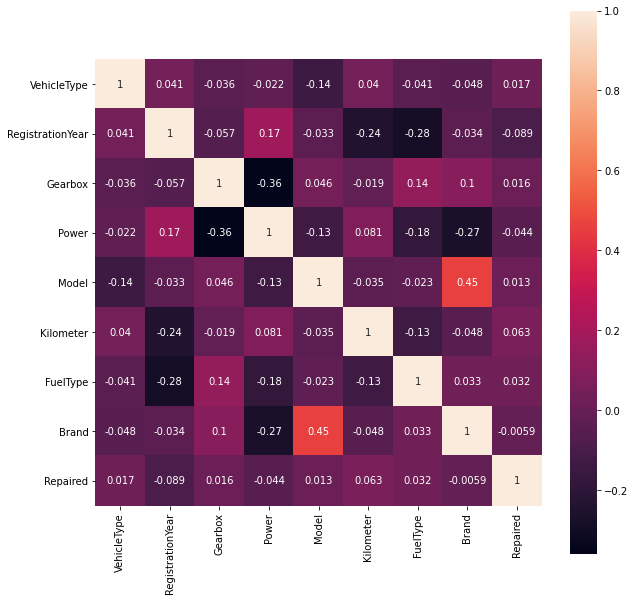

In [83]:
plt.figure(figsize=(10,10))
sns.heatmap(features_train_code.corr(), annot=True, square=True)

Видим корреляцию между параметрами.
Положительная между моделью и брендом, отрицательная между мощностью двигателя и типом коробки передач.
Связи слабее между мощностью двигателя, километражом, типом топлива и годом регистрации авто.

Можно было бы удалить бренд и мощность, но в брендах есть модели other, которые после удаления сольются в один тип, а коробка может стоять на абсолютно одинаковых по мощности машинах, но стоить разнообразно, потому что от типа кпп зависит строение автомобиля.

<AxesSubplot:>

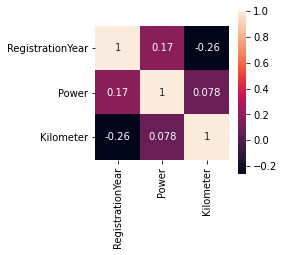

In [84]:
plt.figure(figsize=(3,3))
sns.heatmap(features_train.corr(), annot=True, square=True)

В этом сете почти такая же корреляция между километражом и годом реистрации, как и в полностью закодированном.

## Обучение моделей

In [85]:
model_list = {
    'RMSE': [],
    'Время обучения(сек)': [],
    'Время предсказания(сек)': []
}

В качестве моделей использую DecisionTreeClassifier, CatBoostClassifier, LightGBM.

Алгоритм будет один -  выбрать гиперпараметры, засечь время обучения модели, просчитать модель. Может быть, у меня получится создать функцию для этой цели.

### DecisionTreeRegressor

In [86]:
%%time 
start = time()
model_tree = DecisionTreeRegressor(random_state=RANDOM_STATE)

parameters = {'max_depth' : [3, 16000], 'min_samples_split' : [10, 20], 'min_samples_leaf' : [4, 30]}

grid_tree = GridSearchCV(DecisionTreeRegressor(random_state=RANDOM_STATE), parameters, scoring="neg_root_mean_squared_error", cv = 5, n_jobs= -1)   # , class_weight = 'balanced'
grid_tree.fit(features_train_code, target_train)

print(grid_tree.best_params_)
time_tree = time() - start
print(time_tree)



{'max_depth': 16000, 'min_samples_leaf': 4, 'min_samples_split': 20}
13.561309337615967
CPU times: user 13.6 s, sys: 242 µs, total: 13.6 s
Wall time: 13.6 s


In [87]:
%%time
start = time()
model_tree = DecisionTreeRegressor(max_depth=grid_tree.best_params_.get('max_depth'),\
                                    min_samples_leaf=grid_tree.best_params_.get('min_samples_leaf'),\
                                    min_samples_split= grid_tree.best_params_.get('min_samples_split'))

score_tree = cross_val_score(model_tree, features_train_code, target_train, scoring="neg_root_mean_squared_error", cv=5)

print(score_tree)
time_tree = time() - start
print(time_tree)

[-1777.27317588 -1787.08268086 -1775.38092692 -1760.62535402
 -1777.56474121]
2.813124895095825
CPU times: user 2.81 s, sys: 0 ns, total: 2.81 s
Wall time: 2.81 s


In [88]:
mean_score_tree = np.mean(score_tree)*(-1)
mean_score_tree

1775.5853757775271

In [89]:
model_tree.fit(features_train_code, target_train)


DecisionTreeRegressor(max_depth=16000, min_samples_leaf=4, min_samples_split=20)

In [90]:
%%time

start = time()
predicted_tree = model_tree.predict(features_train_code)

predicted_time = time() - start

CPU times: user 66 ms, sys: 0 ns, total: 66 ms
Wall time: 66 ms


In [91]:
model_list['Время обучения(сек)'].append(time_tree)
model_list['RMSE'].append(mean_score_tree)
model_list['Время предсказания(сек)'].append(predicted_time)


### CatBoostRegressor

In [92]:
%%time

parameters_cat = {'n_estimators': [1, 20, 4], 'max_depth' : [1, 300, 30], 'l2_leaf_reg': [1, 50, 5]}

start = time()                     

grid_cat = GridSearchCV(CatBoostRegressor(random_state=RANDOM_STATE),\
                        parameters_cat, scoring="neg_root_mean_squared_error",\
                        cv=5, n_jobs=-1)

grid_cat.fit(features_train, target_train, silent=True, cat_features=columns_cat)

time_cat = time() - start

print('Best params:', grid_cat.best_params_)
print('time =', time_cat)



Best params: {'l2_leaf_reg': 1, 'max_depth': 1, 'n_estimators': 20}
time = 99.32125091552734
CPU times: user 54.8 s, sys: 493 ms, total: 55.3 s
Wall time: 1min 39s


In [93]:
%%time
start = time()

model_cat = CatBoostRegressor(n_estimators=grid_cat.best_params_.get('n_estimators'),\
                              max_depth=grid_cat.best_params_.get('max_depth'),\
                              l2_leaf_reg=grid_cat.best_params_.get('l2_leaf_reg'),\
                              random_state=RANDOM_STATE, silent=True,\
                              cat_features=columns_cat)


                              
score_cat =cross_val_score(model_cat, features_train, target_train, scoring="neg_root_mean_squared_error", cv=5)

time_cat = time() - start
print('time =', time_cat) 



score_cat

time = 7.945383787155151
CPU times: user 5.05 s, sys: 128 ms, total: 5.18 s
Wall time: 7.95 s


array([-3825.25342484, -3791.31322733, -3804.92588328, -3777.77176225,
       -3780.64894643])

In [94]:
mean_score_cat = np.mean(score_cat)*(-1)
mean_score_cat

3795.9826488246167

In [95]:
model_cat.fit(features_train, target_train, cat_features=columns_cat)

In [96]:
%%time
start = time()
predicted_cat = model_cat.predict(features_train)

predicted_time = time() - start
print('time =', predicted_time)

time = 0.3178431987762451
CPU times: user 315 ms, sys: 0 ns, total: 315 ms
Wall time: 318 ms


In [97]:
model_list['Время обучения(сек)'].append(time_cat)
model_list['RMSE'].append(mean_score_cat)
model_list['Время предсказания(сек)'].append(predicted_time)

In [98]:
del len_df, len_before, len_after, columns, columns_numeric, f, (ax1, ax2), brand_power, auto_model, features_train_code
del features_test_code, encoder, scaler, model_tree, parameters, grid_tree, time_tree, score_tree, mean_score_tree
del predicted_time, parameters_cat, grid_cat, time_cat, score_cat, mean_score_cat, predicted_cat, model_cat

### LGBMRegressor

In [99]:
parameters_lgbm = {
    'max_depth': range(4,10,3),
    'n_estimators': range(1,100,25)
}

    

In [100]:
features_train[columns_cat] = features_train[columns_cat].astype('category')

In [101]:
%%time
lgbm = LGBMRegressor(seed=RANDOM_STATE)
start = time()
grid_lgbm = GridSearchCV(lgbm, parameters_lgbm, cv=5, scoring='neg_mean_squared_error')
grid_lgbm.fit(features_train, target_train, categorical_feature=columns_cat);
grid_lgbm.best_params_
time_lgbm = time() - start
print('Best params:', grid_lgbm.best_params_)
print(time_lgbm)



Best params: {'max_depth': 7, 'n_estimators': 76}
550.9910814762115
CPU times: user 9min 1s, sys: 4.03 s, total: 9min 5s
Wall time: 9min 10s


In [102]:
%%time
start = time()

model_lgbm = LGBMRegressor(max_depth=grid_lgbm.best_params_.get('max_depth'),
                           n_estimators=grid_lgbm.best_params_.get('n_estimators'),
                           seed=RANDOM_STATE)


                                                      
                               
score_lgbm =cross_val_score(model_lgbm, features_train, target_train, scoring="neg_root_mean_squared_error",\
                            cv=5)
score_lgbm
time_lgbm = time() - start
print(time_lgbm)



21.609668970108032
CPU times: user 21.4 s, sys: 85.6 ms, total: 21.5 s
Wall time: 21.6 s


In [103]:
mean_score_lgbm = np.mean(score_lgbm)*(-1)
mean_score_lgbm

1654.3680511379935

In [104]:
model_lgbm.fit(features_train, target_train, categorical_feature=columns_cat)

LGBMRegressor(max_depth=7, n_estimators=76, seed=123)

In [105]:
%%time
start = time()
predicted_lgbm = model_lgbm.predict(features_train)

predicted_time = time() - start



CPU times: user 1.87 s, sys: 0 ns, total: 1.87 s
Wall time: 1.91 s


In [106]:
model_list['Время обучения(сек)'].append(time_lgbm)
model_list['RMSE'].append(mean_score_lgbm)
model_list['Время предсказания(сек)'].append(predicted_time)

In [107]:
model_list

{'RMSE': [1775.5853757775271, 3795.9826488246167, 1654.3680511379935],
 'Время обучения(сек)': [2.813124895095825,
  7.945383787155151,
  21.609668970108032],
 'Время предсказания(сек)': [0.06596231460571289,
  0.3178431987762451,
  1.9063165187835693]}

In [108]:
model_rating_table = {
    'Model': ['DecisionTree', 'CatBoost', 'LightGBM'],
    'RMSE': model_list['RMSE'],
    'Время обучения(сек)': model_list['Время обучения(сек)'],    
    'Время предсказания(сек)': model_list['Время предсказания(сек)']
}

In [109]:
model_rating_table = pd.DataFrame(model_rating_table)
model_rating_table.sort_values('RMSE', ascending=False).style.highlight_min(subset=['RMSE',\
                                                             'Время обучения(сек)', 'Время предсказания(сек)'])

,Model,RMSE,Время обучения(сек),Время предсказания(сек)
1,CatBoost,3795.982649,7.945384,0.317843
0,DecisionTree,1775.585376,2.813125,0.065962
2,LightGBM,1654.368051,21.609669,1.906317


Получается, что моделью выбора становится LGBM с лучшей из полученных метрик RMSE.

## Анализ моделей

Запустим выбранную модель на тестовой выборке.

###### LGBMRegressor

In [110]:
features_test[columns_cat] = features_test[columns_cat].astype('category')

In [111]:
%%time

start = time()
predicted_lgbm = model_lgbm.predict(features_test)

predicted_time = round(time() - start,2)
rmse_lgbm = round(mean_squared_error(target_test, predicted_lgbm) ** 0.5,6)

print('Время предсказания(сек): ', predicted_time)
print('RMSE: ', rmse_lgbm)



Время предсказания(сек):  0.45
RMSE:  1668.57466
CPU times: user 502 ms, sys: 0 ns, total: 502 ms
Wall time: 454 ms


Text(0.5, 1.0, 'Correlation Heatmap\n')

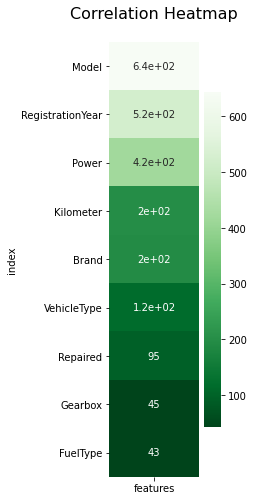

In [112]:
feature_names = features_train.columns
model_importances = pd.Series(model_lgbm.feature_importances_, index=feature_names).reset_index()
model_importances.index=model_importances['index']
model_importances.rename(columns={0:'features'}, inplace=True)
plt.figure(figsize=(2,8))
sns.heatmap(model_importances[['features']].sort_values(by='features',ascending=False),\
            annot=True, cmap='Greens_r')
plt.title('Correlation Heatmap'+'\n',fontsize=16)

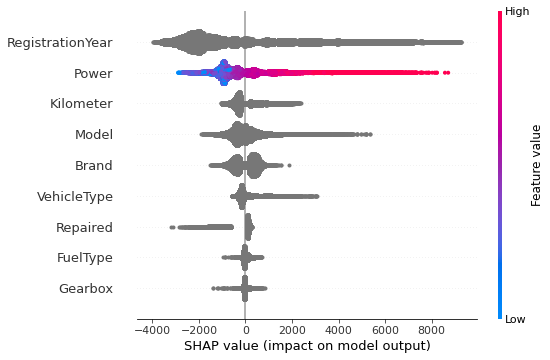

In [115]:
import shap

shap_test = shap.TreeExplainer(model_lgbm).shap_values(features_test)
shap.summary_plot(shap_test, features_test,
                      max_display=30, auto_size_plot=True)


## Вывод

В работе проведён анализ данных: убраны полные дубли, изъяты данные с ошибочными датами, низкой ценой (до 100 евро), исключены признаки PostalCode, LastSeen, NumberOfPictures по причине неинформативности, заполнены пропуски. 

Для обучения модели DecisionTree кодирую категориальные признаки и масштабирую числовые, для моделей CatBoost и LGBM провожу только масштабирование числовых признаков, потому что эти модели сами обрабатывают категориальные признаки.

С помощью gridSearch подбираю оптимальные параметры моделей и на кроссвалидации рассчитываю метрику RMSE. Составляю сводную таблицу интересующих параметров работы модели - метрика RMSE, время обучения и время предсказания.

In [116]:
model_rating_table

,Model,RMSE,Время обучения(сек),Время предсказания(сек)
0,DecisionTree,1775.585376,2.813125,0.065962
1,CatBoost,3795.982649,7.945384,0.317843
2,LightGBM,1654.368051,21.609669,1.906317


Таблица показывает, что лучше всех метрика у модели LGBM. Параметры модели: max_depth=7, n_estimators=76, seed=123. Далее я тестирую эту модель на тестовой выборке, получая следующие данные: 

In [117]:
print('Время обучения(сек): ', time_lgbm)
print('Время предсказания(сек): ', predicted_time)
print('RMSE: ', rmse_lgbm)

Время обучения(сек):  21.609668970108032
Время предсказания(сек):  0.45
RMSE:  1668.57466


Анализ важности признаков показывает, что модель LGBM  для определения цены автомобиля в текущих данных считает важными модель автомобиля, год регистрации автомобиля и мощность двигателя. Был ли автомобиль в ремонте, коробка передач и тип используемого топлива практически не имеют влияния на формирование цены.